In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df = pd.read_csv("vod_cohorts.txt", sep="\t", header=None)

# Preprocess the data and split customers into 2 groups

In [3]:
def preprocess(df):
    """take raw data and process to return initial cohort and returning one"""
    df.columns = ['encrypted_customer_Id','first_purchase','transaction_date','content_type']
    #add transaction field
    df['transaction'] = 1
    
    df['first_purchase'] = pd.to_datetime(df['first_purchase'])
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])

    
    #add dataframe to groupby by customer_id
    t = pd.pivot_table(df, index = 'encrypted_customer_Id',
                       columns='content_type', values = 'transaction' ,
                       aggfunc = 'sum').reset_index()
    t = t.fillna(0)
    
    #add classes
    t['class'] = "NA"
    t['class'] = np.where(t['Movie EST'] == 0 , 'VOD Only', t['class'])
    t['class'] = np.where(t['Movie VOD'] == 0, 'Onlye_first_time_VOD', t['class'])
    t['class'] = np.where((t['Movie VOD'] == 0) | (t['Movie EST'] > 0) , 'Mixed', t['class'])
    t['total_units'] = t['Movie VOD'] + t['Movie EST'] + 1
    
    
    #create period column based on transaction date
    df['order_period'] = df['transaction_date'].apply(lambda x: x.strftime('%Y-%m'))

    #determine user s cohort group
    df['cohort_group'] = df['first_purchase'].apply(lambda x : x.strftime('%Y-%m'))
    
    df_new = pd.merge(left=df,right=t,
                  left_on='encrypted_customer_Id',
                  right_on='encrypted_customer_Id', how="left")
    
    return df_new, t

In [4]:
df_new, t = preprocess(df)

In [5]:
df_new.head()

,encrypted_customer_Id,first_purchase,transaction_date,content_type,transaction,order_period,cohort_group,Movie EST,Movie VOD,class,total_units
0,A8XJNM5X8008M,2016-04-02,2016-04-04,Movie VOD,1,2016-04,2016-04,0.0,12.0,VOD Only,13.0
1,A365VJ4VMPBLC,2016-03-06,2016-06-13,Movie VOD,1,2016-06,2016-03,51.0,148.0,Mixed,200.0
2,ATFVH4L38OZAF,2016-01-02,2016-08-05,Movie EST,1,2016-08,2016-01,33.0,17.0,Mixed,51.0
3,A370OUC2FAMFF0,2016-09-23,2016-09-28,Movie VOD,1,2016-09,2016-09,38.0,133.0,Mixed,172.0
4,A18MFDSY5MG1BL,2016-05-20,2016-10-28,Movie VOD,1,2016-10,2016-05,4.0,295.0,Mixed,300.0


## Prepare cohorts and return rates for both groups

In [63]:
def group_by_class(df):
   
    #Important, to eliminate outliers, exclude most recent month
    df_new = df[df['order_period'] < df['order_period'].max()]
        
    grouped = df_new.groupby(['cohort_group', 'order_period', 'class'])
    cohorts = grouped.agg({'encrypted_customer_Id': pd.Series.nunique}).reset_index()
    total_cohort_size = pd.DataFrame(df_new.groupby(['cohort_group',
    'class'])['encrypted_customer_Id'].nunique().reset_index())
    
    summary = pd.merge(left=cohorts,
                  right=total_cohort_size,
                  left_on=['cohort_group','class'],
                  right_on=['cohort_group','class'], how = 'left')
    summary['ratio'] = summary['encrypted_customer_Id_x'] / summary['encrypted_customer_Id_y']
    
    #back to pd_to_datetime
    summary['order_period'] = pd.to_datetime(summary['order_period'])
    summary['cohort_group'] = pd.to_datetime(summary['cohort_group'])
    #Time diff of order_period relative to cohort_group
    summary['cohort_period'] = round((summary['order_period'] 
                             - summary['cohort_group']) / np.timedelta64(1,'M'),0)
    
    return summary

In [64]:
summary = group_by_class(df_new)

In [65]:
summary.tail()

,cohort_group,order_period,class,encrypted_customer_Id_x,encrypted_customer_Id_y,ratio,cohort_period
697,2018-01-01,2018-01-01,VOD Only,4619,8071,0.572296,0.0
698,2018-01-01,2018-02-01,Mixed,2559,3412,0.750000,1.0
699,2018-01-01,2018-02-01,VOD Only,5151,8071,0.638211,1.0
700,2018-02-01,2018-02-01,Mixed,1411,1411,1.000000,0.0
701,2018-02-01,2018-02-01,VOD Only,4003,4003,1.000000,0.0


In [66]:
#Sanity check
df_new[ (df_new['cohort_group'] == '2016-01') 
       & (df_new['order_period'] == '2016-01')
       & (df_new['class'] == 'Mixed')]['encrypted_customer_Id'].nunique()

4080

## Visualize

https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python

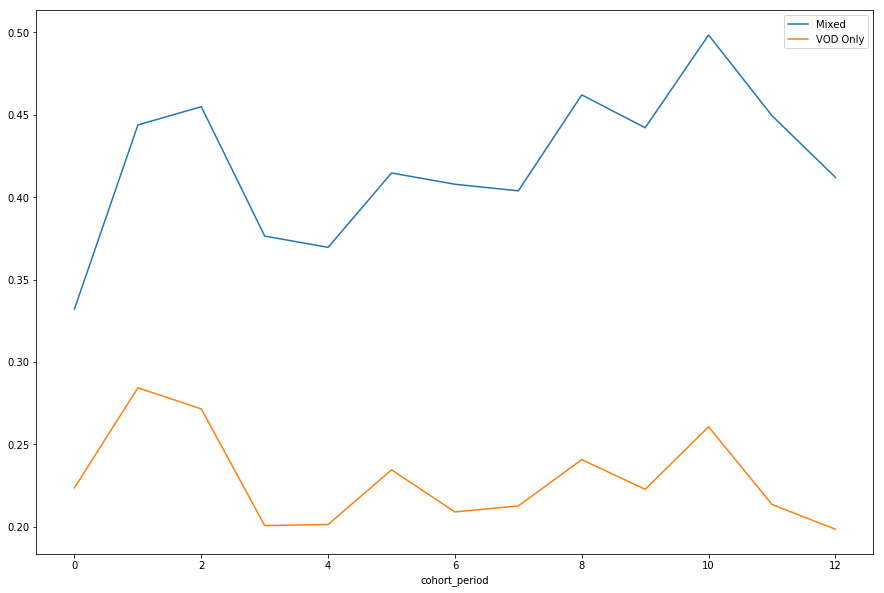

In [67]:
d = summary[summary['cohort_group' ] == '2017-02-01']

plt.figure(figsize = (15,10))
d.set_index('cohort_period', inplace=True)
d.groupby('class')['ratio'].plot(legend=True)
plt.show()

## Create difference in cohorts

In [68]:
def make_visualization(df):
    """return dataframe suitable for visualization"""
    
    s = df[['cohort_group','cohort_period','class','ratio']]
    s = pd.pivot_table(data = s, index=['cohort_group','cohort_period'],columns='class',
                  values = 'ratio').reset_index()
    s['cohort_group'] = s['cohort_group'].apply(lambda x : x.strftime('%Y-%m'))
    s['diff'] = s['Mixed'] - s['VOD Only']
    
    #Set index for groupby plot!
    s.set_index('cohort_period', inplace=True) 
    return s

In [69]:
s = make_visualization(summary)

In [70]:
s.head()

class,cohort_group,Mixed,VOD Only,diff
cohort_period,,,,
0.0,2016-01,0.313148,0.206100,0.107048
1.0,2016-01,0.402103,0.235983,0.166120
2.0,2016-01,0.411543,0.227049,0.184495
3.0,2016-01,0.334792,0.151777,0.183015
4.0,2016-01,0.337555,0.162148,0.175406


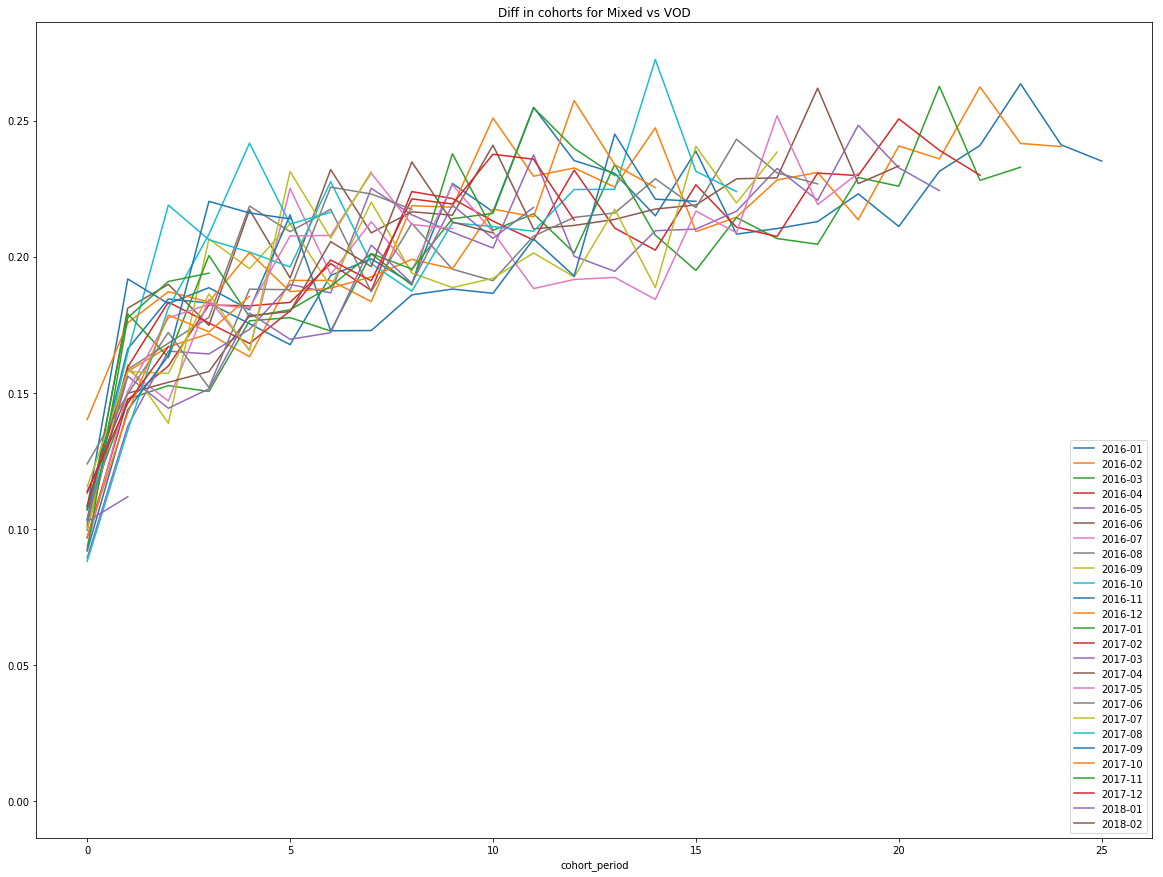

In [71]:
#plot below produces individual plots for each group
#s.groupby(['cohort_group']).plot(x = 'cohort_period',y = 'diff')

plt.figure(figsize = (20,15))
s.groupby('cohort_group')['diff'].plot(legend=True, title = 'Diff in cohorts for Mixed vs VOD')

plt.show()

## Calculate average time span btw VOD and first EST

In [72]:
def find_first_date_within_group(df):
    """returns the first date within group """
    #Make subset
    subset_EST = df[(df['content_type'] == 'Movie EST') & (df['class'] == 'Mixed')]
    
    t = subset_EST.loc[subset_EST.groupby('encrypted_customer_Id').transaction_date.idxmin()]
    t['diff_btw_first_EST_first_ever'] = (t['transaction_date'] - t['first_purchase']) / np.timedelta64(1,"D")
    return t

In [73]:
t = find_first_date_within_group(df_new)

In [74]:
# Sanity check
df_new[df_new['encrypted_customer_Id'] == 'A00035188K6CXZDRM4MC'].sort_values(by = 'transaction_date'
                                                                              , ascending = True).head()

,encrypted_customer_Id,first_purchase,transaction_date,content_type,transaction,order_period,cohort_group,Movie EST,Movie VOD,class,total_units
1174783,A00035188K6CXZDRM4MC,2016-12-23,2016-12-26,Movie EST,1,2016-12,2016-12,4.0,2.0,Mixed,7.0
1585330,A00035188K6CXZDRM4MC,2016-12-23,2017-04-14,Movie EST,1,2017-04,2016-12,4.0,2.0,Mixed,7.0
1207796,A00035188K6CXZDRM4MC,2016-12-23,2017-05-25,Movie EST,1,2017-05,2016-12,4.0,2.0,Mixed,7.0
1552174,A00035188K6CXZDRM4MC,2016-12-23,2017-10-14,Movie VOD,1,2017-10,2016-12,4.0,2.0,Mixed,7.0
1830102,A00035188K6CXZDRM4MC,2016-12-23,2017-11-12,Movie EST,1,2017-11,2016-12,4.0,2.0,Mixed,7.0


In [75]:
t[t['encrypted_customer_Id'] == 'A00035188K6CXZDRM4MC']

,encrypted_customer_Id,first_purchase,transaction_date,content_type,transaction,order_period,cohort_group,Movie EST,Movie VOD,class,total_units,diff_btw_first_EST_first_ever
1174783,A00035188K6CXZDRM4MC,2016-12-23,2016-12-26,Movie EST,1,2016-12,2016-12,4.0,2.0,Mixed,7.0,3.0


In [76]:
t['diff_btw_first_EST_first_ever'].mean()

174.24120123720891

In [77]:
t['diff_btw_first_EST_first_ever'].describe()

count    220173.000000
mean        174.241201
std         170.644587
min           1.000000
25%          35.000000
50%         118.000000
75%         270.000000
max         794.000000
Name: diff_btw_first_EST_first_ever, dtype: float64

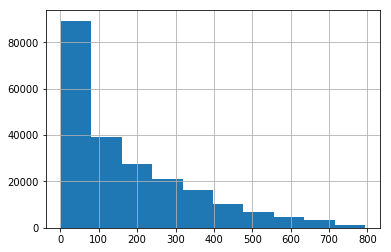

In [78]:
t['diff_btw_first_EST_first_ever'].hist()